# Red Sox Pregame Analysis

This notebook explores T traffic before Sox games.

## Setup

In [145]:
# Libraries.
import datetime as dt
import math
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [3]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [27]:
# Other settings.

# Default figure size.
default_figsize = (12,8)

# Base units of timedeltas.
timedelta_base = 3.6e12

## Data

In [4]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
sox.game_time = pd.DatetimeIndex(sox.game_datetime).time
sox.game_time_rounded = pd.DatetimeIndex(sox.game_datetime_rounded).time

In [ ]:
sox.head()

In [9]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to columns that we need.
gatecount = gatecount.ix[:,['locationid','name','line_1','line_2','service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
gatecount.service_day = pd.to_datetime(gatecount.service_day)
gatecount.service_datetime = pd.to_datetime(gatecount.service_datetime)

# Get time of day.
gatecount['service_time'] = pd.DatetimeIndex(gatecount.service_datetime).time

# Add day of week.
gatecount = date.add_day_of_week(gatecount.copy())

In [ ]:
gatecount.head()

In [198]:
# Perform merge.
gatecount_sox = gatecount.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
gatecount_sox['game_played'] = (gatecount_sox.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
gatecount_sox['time_until_game_start'] = gatecount_sox.game_datetime_rounded - gatecount_sox.service_datetime

# Separate into classes: weekday/weekend and early/late.
gatecount_sox['day_of_week_class'] = 'Weekday'
gatecount_sox.ix[gatecount_sox.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
gatecount_sox['game_time_class'] = 'Early'
gatecount_sox.ix[gatecount_sox.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

# Add line count and an "entries per line" column for each station.
gatecount_sox['lines'] = 1
gatecount_sox.ix[gatecount_sox.line_2.isnull() == False,'lines'] = 2
gatecount_sox['entries_per_line'] = gatecount_sox.entries / gatecount_sox.lines

# Clean up lines.
gatecount_sox.line_1 = ['None' if type(l) == float and math.isnan(l) else l for l in gatecount_sox.line_1]
gatecount_sox.line_2 = ['None' if type(l) == float and math.isnan(l) else l for l in gatecount_sox.line_2]

In [199]:
gatecount_sox[gatecount_sox.game_played].head()

,locationid,name,line_1,line_2,service_day,service_datetime,entries,service_time,day_of_week,game_date,...,opponent,game_datetime,game_time_rounded,game_datetime_rounded,game_played,time_until_game_start,day_of_week_class,game_time_class,lines,entries_per_line
492838,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 04:45:00,1,04:45:00,0,2013-04-08,...,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,09:15:00,Weekday,Early,1,1
492839,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:00:00,8,05:00:00,0,2013-04-08,...,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,09:00:00,Weekday,Early,1,8
492840,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:15:00,81,05:15:00,0,2013-04-08,...,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,08:45:00,Weekday,Early,1,81
492841,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:30:00,57,05:30:00,0,2013-04-08,...,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,08:30:00,Weekday,Early,1,57
492842,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:45:00,48,05:45:00,0,2013-04-08,...,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,08:15:00,Weekday,Early,1,48


### Aggregate, Controlling for Day of Week

Let's compare entries across the system on gamedays to days with no games, controlling for day of week.

In [200]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gameless_entries_dow = gatecount_sox[gatecount_sox.game_played == False]

# Aggregate.
gameless_entries_dow = gameless_entries_dow.groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries': np.mean, 'entries_per_line': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries', 'entries_per_line': 'mean_entries_per_line'}, inplace=True)

In [207]:
# Only consider entries before the game or slightly into it (to determine when entries dissipate.
gametime_condition = ((gatecount_sox.time_until_game_start <= np.timedelta64(6,'h')) & (gatecount_sox.time_until_game_start >= np.timedelta64(-90,'m')))
game_entries_dow = gatecount_sox[gatecount_sox.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','line_1','line_2','day_of_week','service_time'])[['name','line_1','line_2','entries','entries_per_line','time_until_game_start','mean_entries','mean_entries_per_line']]
entry_differences_dow['entries_vs_mean'] = entry_differences_dow.entries - entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_ratio'] = entry_differences_dow.entries / entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_per_line'] = entry_differences_dow.entries_per_line - entry_differences_dow.mean_entries_per_line
entry_differences_dow['entries_vs_mean_per_line_ratio'] = entry_differences_dow.entries_per_line / entry_differences_dow.mean_entries_per_line

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_dow = entry_differences_dow.groupby(['name','line_1','line_2','time_until_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std],
        'entries_vs_mean_per_line': [np.mean,np.std],
        'entries_vs_mean_per_line_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_dow.time_until_game_start = pd.to_timedelta(mean_entry_differences_dow.time_until_game_start)
mean_entry_differences_dow['hours_until_game_start'] = mean_entry_differences_dow.time_until_game_start.astype(np.int) / timedelta_base

In [210]:
mean_entry_differences_dow.head()

name line_1 line_2  time_until_game_start  \
                                                  
0  Airport   Blue   None              -01:30:00   
1  Airport   Blue   None              -01:15:00   
2  Airport   Blue   None              -01:00:00   
3  Airport   Blue   None              -00:45:00   
4  Airport   Blue   None              -00:30:00   

   entries_vs_mean_per_line_ratio            entries_vs_mean_per_line  \
                             mean       std                      mean   
0                        1.107585  0.344592                  9.132825   
1                        1.177203  0.365419                 12.531234   
2                        1.117898  0.360017                  8.952860   
3                        1.192449  0.363839                 13.145667   
4                        1.188326  0.405469                 13.878554   

              entries_vs_mean             entries_vs_mean_ratio            \
         std             mean        std                   mean       std   
0  33.421348         9.132825  33.421348               1.107585  0.344592   
1  30.105912        12.531234  30.105912               1.177203  0.365419   
2  32.468966         8.952860  32.468966               1.117898  0.360017   
3  29.843984        13.145667  29.843984               1.192449  0.363839   
4  35.869526        13.878554  35.869526               1.188326  0.405469   

   hours_until_game_start  
                           
0                   -1.50  
1                   -1.25  
2                   -1.00  
3                   -0.75  
4                   -0.50

In [ ]:
# Extract useful information.
mean_entry_differences_dow_truncated = mean_entry_differences_dow[[0,1,2,12,8,6]].copy()
mean_entry_differences_dow_truncated.columns = mean_entry_differences_dow_truncated.columns.get_level_values(0)
mean_entry_differences_dow_truncated

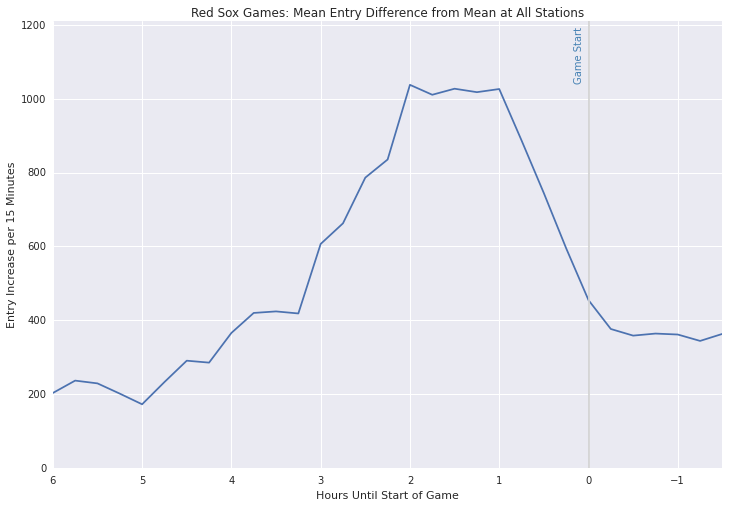

In [213]:
# Plot aggregate.

# Group by hours until start and aggregate.
mean_entry_differences_dow_agg = mean_entry_differences_dow_truncated.groupby('hours_until_game_start').agg(np.sum).reset_index()

# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_dow_agg.hours_until_game_start, mean_entry_differences_dow_agg.entries_vs_mean)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at All Stations')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

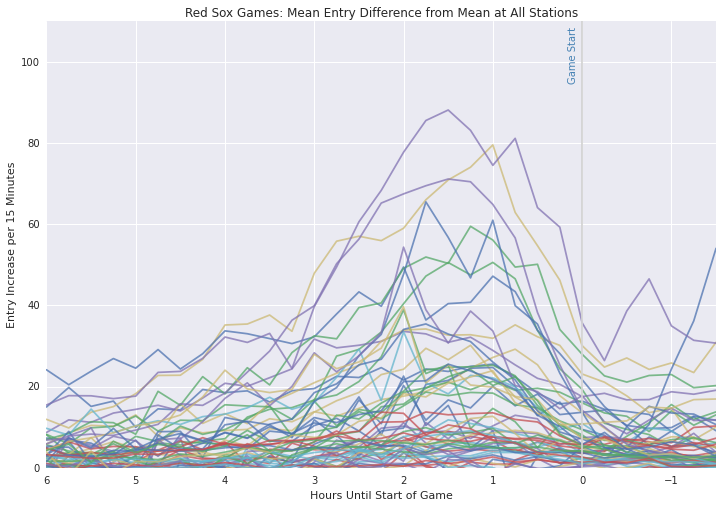

In [214]:
# Now plot them. Plot one line per station.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for station in mean_entry_differences_dow.name.unique():
    # Get station entries.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    plt.plot(station_entry_differences.hours_until_game_start, station_entry_differences.entries_vs_mean['mean'], label=station, alpha=0.75)
    # Add note about total over time range.

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
plt.axvline(0, *ylim, color='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at All Stations')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

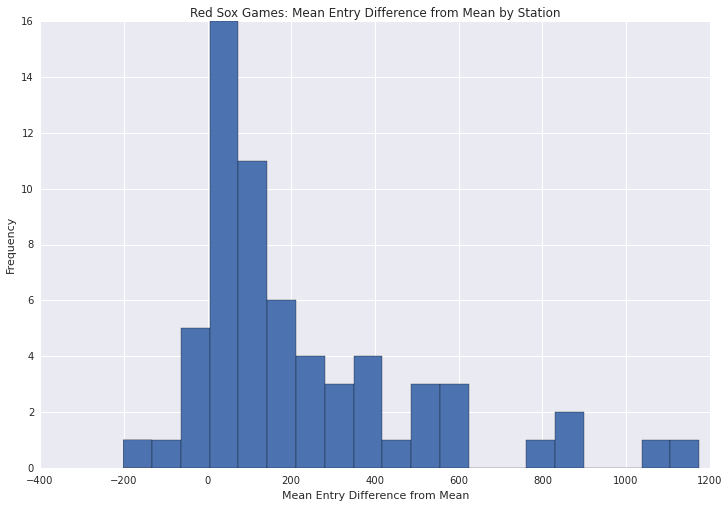

In [224]:
# Calculate sums for each station and plot distribution.

# Calculate sum for each station.
mean_entry_differences_dow_by_station = mean_entry_differences_dow_truncated.ix[mean_entry_differences_dow_truncated.hours_until_game_start > -.5,:].groupby(['name','line_1','line_2']).agg({'entries_vs_mean': np.sum})

# Start plotting.
plt.figure(figsize=default_figsize)
plt.hist(mean_entry_differences_dow_by_station.entries_vs_mean, bins=20)

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean by Station')
plt.xlabel('Mean Entry Difference from Mean'); plt.ylabel('Frequency')

# Show.
plt.show()

In [273]:
# Show those particular stations.
mean_entry_differences_dow_by_station.sort('entries_vs_mean', ascending=False).head(n=10)

,,,entries_vs_mean
name,line_1,line_2,
Park Street,Green,Red,1174.793376
Government Center,Green,Blue,1068.297482
Riverside,Green,None,888.205871
Harvard,Red,None,840.635454
Haymarket,Orange,Green,790.403362
Aquarium,Blue,None,578.837631
Alewife,Red,None,569.929181
North Station,Orange,Green,556.853073
Copley Square,Green,None,549.368358


In [249]:
# Plot lines at individual times.
# Because lines are split by container, we need to be creative.
line_entries = pd.DataFrame(columns=['line','hours_until_game_start','entries_vs_mean_per_line'])

# Traverse all lines. line_1 has all unique lines.
for line in mean_entry_differences_dow_truncated.line_1.unique():
    # Get traffic for that line, group
    line_condition = ((mean_entry_differences_dow_truncated.line_1 == line) | (mean_entry_differences_dow_truncated.line_2 == line))
    line_traffic = mean_entry_differences_dow_truncated.ix[line_condition,:]
    line_traffic = line_traffic.groupby('hours_until_game_start').agg({'entries_vs_mean_per_line':np.sum}).reset_index()
    line_traffic['line'] = line
    line_traffic = line_traffic[[2,0,1]]
    # Append.
    line_entries = line_entries.append(line_traffic)

# Cleanup.
line_entries.reset_index(inplace=True, drop=True)

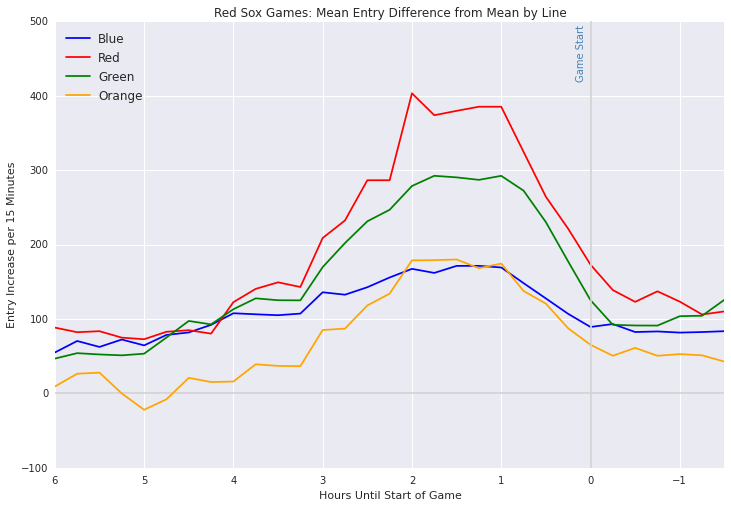

In [270]:
# Plot.

# Start plot.
plt.figure(figsize=default_figsize)
for line in line_entries.line.unique():
    if line != 'Silver':
        plt.plot(line_entries.ix[line_entries.line == line,'hours_until_game_start'], line_entries.ix[line_entries.line == line,'entries_vs_mean_per_line'], c=line, label=line)

# Fix x limit and add origin lines.
xlim = plt.xlim((-1.5, plt.xlim()[1])); ylim = (plt.ylim()[0],plt.ylim()[1]*1.0)
plt.axvline(0, *ylim, color='lightgray')
plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')
plt.ylim(ylim)

# Reverse axis.
plt.gca().invert_xaxis()

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean by Line')
plt.xlabel('Hours Until Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.legend(loc=2, fontsize='large')

# Show.
plt.show()